# Section 1: Dataset Generation and Preprocessing

We are supposed to train a model that takes in a blog post and estimates the person's Gender and Horoscopic star. We have a dataset of XML files that contain the posts and in the name of the file is contained the the Gender and the Star of that person.

1. <strong>Get Paths</strong>

  We Use os method `listdir` to get all the name of the files in a list. We store it in a variable named `xml_paths`.

2. <strong>Get required data</strong>

  - We have a variable `data_in_list` which is a list of lists, which will hold the required data.
  - For Every XML file found in the `xml_paths`
    - We Get the `gender` and `star` from the file name
    - We Open the file using a context manager and get the content of the file using the `read` method.
    - We then use the `chardet` module to determine the type of encoding present in the content. Chardet's method `detect` takes in the content and spits out a dictionary containing the type of encoding and the confidence associated to it.
    - We then create a `BeautifulSoup` object named `soup`. We pass it the `content`, `xml` mode and the `type of encoding` (given from chardet) which it needs to use while reading the content.
    - Then we use the `find_all` method and pass it the string `'post'`.
    - Now for every post found per file we
      - Get the post's text using the `get_text` method.
      - LowerCase the post content
      - Remove Numbers from the content
      - Remove Punctuations
      - Remove Whitespaces
      - We remove the stopwords from the data using the `nltk.corpus`'s `stopwords`
      - We do lemmatization to bring every word to it's parent form. We use `nltk.stem`'s `WordNetLemmatizer` for the purpose.
      - Remove URLs
      - Spell Checking. Now the problem is that spell cheking module takes huge amount of time to correct the spellings. I have commented out the Spell Checking part because of less time. But we can include it for the processing of our text data.
    - After the pre-processing of the data, we append it to the `data_in_list` list in the format of `[post, gender, star]`
  - Now we have a list containing `594205` posts in it.
  - We use the `data_in_list` variable to create a `Pandas Dataframe`. We have a data frame with headers `Post, Gender, Star` and the corresponding data.
  - We simply save the dataframe locally in the format of a `csv`.

In [1]:
from os import listdir
from bs4 import BeautifulSoup
import chardet
from tqdm import tqdm
import pandas as pd
import re
import string
from spellchecker import SpellChecker

In [2]:
# Get file names of all the xmls
xml_paths = listdir("./data/blogs_train/")

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ibtihaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ibtihaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ibtihaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ibtihaj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# A list of lists containing the Post, Gender and Star as the elements
# [[Post, Gender, Star]]
data_in_list = list()

# For every file in folder
for file in tqdm(xml_paths):

    # Get the gender from the file name
    gender = file.split('.')[1]

    # Get the star from the file name
    star = file.split('.')[-2]

    # Start reading the XML Files in binary mode
    with open(f"./data/blogs_train/{file}", 'rb') as xml_file:

        # Read the content
        content = xml_file.read()

        # Detect type of Encoding
        encoding = chardet.detect(content)

        # Create a BeautifulSoup Object with the detected encoding
        soup = BeautifulSoup(
            content, 'xml', from_encoding=encoding['encoding'])

        # Get all the posts found per file
        posts = soup.find_all('post')

        # For every post found per file
        for post in posts:

            # Preprocessing

            # Get the post text in `str` format
            post_text = post.get_text()

            # 1. LowerCase the text
            text_lower = post_text.lower()

            # 2. Remove Numbers
            text_wo_numbers = re.sub(r'\d+', '', text_lower)

            # 3. Remove Punctuations
            PUNCT_TO_REMOVE = string.punctuation
            text_wo_punctuation = text_wo_numbers.translate(
                str.maketrans('', '', PUNCT_TO_REMOVE))

            # 4. Remove White Space
            text_wo_whitespace = text_wo_punctuation.strip()

            # 5. Remove Stop Words
            STOPWORDS = set(stopwords.words('english'))
            text_wo_stop = " ".join([word for word in str(
                text_wo_whitespace).split() if word not in STOPWORDS])

            # 6. Lemmatization
            lemmatizer = WordNetLemmatizer()
            wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB,
                           "J": wordnet.ADJ, "R": wordnet.ADV}
            pos_tagged_text = nltk.pos_tag(text_wo_stop.split())
            text_lemmatized = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(
                pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

            # 7. Removal of URLs
            url_pattern = re.compile(r'https?://\S+|www\.\S+')
            text_wo_urls = url_pattern.sub(r'', text_lemmatized)

#             # 8. Spell Checking
#             spell = SpellChecker()
#             def correct_spellings(text):
#                 corrected_text = []
#                 misspelled_words = spell.unknown(text.split())
#                 for word in text.split():
#                     if word in misspelled_words:
#                         corrected_text.append(spell.correction(word))
#                     else:
#                         corrected_text.append(word)
#                 return " ".join(corrected_text)

#             text_with_spellchk = correct_spellings(text_wo_urls)

            # Append the Post, Gender and Star to the list
            data_in_list.append([text_wo_urls, gender, star])

100%|██████████| 14600/14600 [1:51:52<00:00,  2.18it/s]  


In [6]:
# Create a dataframe of the generated data
df = pd.DataFrame(data_in_list, columns=['post', 'gender', 'star'])

In [7]:
# Save data locally in the format of a CSV
df.to_csv('./data/processed_data.csv', header=True, index=None)

# Section 2: Analysis

In this section we do some simple analysis of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [43]:
# Path to the above generated csv
path_to_csv = "./data/processed_data.csv"

In [44]:
# Load the data
data = pd.read_csv(path_to_csv)

# Drop 'nan' rows
data.dropna(inplace=True)

In [4]:
# Print Samples
print(f"Input data columns: {data.columns}")
print(f"Number of samples: {len(data)}")

Input data columns: Index(['post', 'gender', 'star'], dtype='object')
Number of samples: 590966


Text(0, 0.5, 'samples')

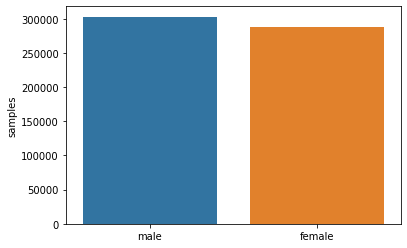

In [5]:
# Plot against Gender

x = data.gender.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

In [6]:
# Gender Value Count
data['gender'].value_counts()

male      303052
female    287914
Name: gender, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

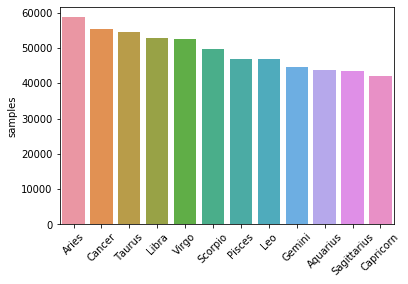

In [7]:
# Plot against Horoscopic Star

x = data.star.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')
plt.xticks(rotation=45)

In [8]:
# Star Value Count
data['star'].value_counts()

Aries          58641
Cancer         55404
Taurus         54625
Libra          52660
Virgo          52643
Scorpio        49634
Pisces         46837
Leo            46816
Gemini         44617
Aquarius       43600
Sagittarius    43462
Capricorn      42027
Name: star, dtype: int64

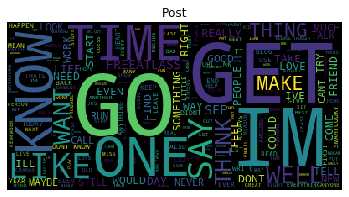

In [9]:
# Create a Word Cloud
def cloud(text):
    wordcloud = WordCloud(background_color="black", stopwords=stop).generate(
        " ".join([i for i in text.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Post")


# Make a word cloud for first 500 posts
cloud(data['post'][:500])

# Section 3: Model

Once we have our data in a dataframe, we are ready to do the further processing.

1. <strong>Further Processing</strong>
  
  - We use the `LabelEncoder` class from `sklearn.preprocessing` to encode the labels into integer form. We do encoding for both `star` and `gender`.
  
  - After getting the values from the dataframe, we `one-hot-encode` all the labels. Why? Because assigning raw ints to the labels adds bias to them. 1 < 7. So the class '1' will have less impact over other labels.
  
  - After that we make a `train_test_split`. Note that i'm only using 20,000 data points because of the low end machine i'm using. It takes around 55 minutes per epoch if i try to train the model on ~500,000 data points. We make a split of 80:20 ratio for train_test data. We also set a `random_state` to reproduce the results.
  
  - The next step is to get the posts from the dataframe and `tokenize` them. We use the `Tokenizer` from `tensorflow.keras.preprocessing.text` for the purpose. After making an instance of the `Tokenizer` class, we tokenize the data present in `train_data` and `test_data`. We also get the `vocab_size` as it will be used latter on in the training of the model.
  
  - We then set a `max_len` variable which sets a fixed length for every post found. Using this max_len variable, we then simply pad the sequence to be of equal size. For pedding we use `pad_sequences` from `tensorflow.keras.preprocessing.sequence`.
  
  
2. <strong>Model Construction</strong>

  - In this phase we create a simple `Sequential` model.
    - We first add an `Embedding` layer to our Sequential model. The purpose of embedding layer is to convert all of the positive integers to fixed length vectors. We provide and `input_size` of `vocab_size` we declared above. We also define the `input_length` which is equal to the `max_len` variable.
    
    - We then add 3 `Dense` layers starting from 128 neurons decending down to 32 neurons with the activation of `relu`
    
    - We add a `Dropout` layer for the purpose of `regularization`.
    
    - We add a `Flatten` layer to flat out the output.
    
    - We then have 2 `Dense` Layers which we will use for classification.
  - We then compile this model using `adam` as `optimizer` and `categorical_crossentropy` as the loss function.
  
  - We then simply create a checkpoints directory in which the model's checkpoints will be saved. We also set callbacks. We use `ModelCheckpoint` to save the models and `EarlyStopping` to stop the training to avoide over fitting. We then return the model along with the callbacks list.

  - We then train the model for 20 epochs with a bath size of 10.
  
  - After the training we plot the training history of the model.

In [10]:
# Import required libararies
from os import makedirs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
# Encode the labels (Simple Label Encoding)
encoder = LabelEncoder()

# Encode the star
data['star_labels'] = encoder.fit_transform(data['star'])

# Encode the gender
data['gender_labels'] = encoder.fit_transform(data['gender'])
data.head()

,post,gender,star,star_labels,gender_labels
0,procrastination procrastination n l procrastin...,female,Pisces,7,0
1,writer people sit write hazard every time comp...,female,Pisces,7,0
2,grrwriters block much pressure since first blo...,female,Pisces,7,0
3,awhile sister move back house little ago effor...,female,Pisces,7,0
4,happen associate certain sound smells place ev...,female,Pisces,7,0


In [12]:
# Get the datapoints and corresponding labels from the dataframe
data_points = data['post'].values
labels = data['labels'].values

In [13]:
# One hot encode the labels

# Reshape from (n_samples,) to (n_samples, 1)
labels = labels.reshape((labels.shape[0], 1))

# Make OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse=False)

# OneHotEncode the labels
labels = one_hot_encoder.fit_transform(labels)

In [14]:
# Split the data into train_test set
train_data, test_data, train_labels, test_labels = train_test_split(
    data_points[:20000], labels[:20000], test_size=0.2, random_state=42)

In [15]:
# Tokenize the data
tokenizer = Tokenizer()

# Fit on train_data
tokenizer.fit_on_texts(train_data)

# Convert the tokens to sequences
train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)

# Get the Vocab Size
vocab_size = len(tokenizer.word_index) + 1

In [16]:
# Pad the sequence to make all of same length
max_len = 250

train_data = pad_sequences(train_data, padding='post', maxlen=max_len)
test_data = pad_sequences(test_data, padding='post', maxlen=max_len)

In [17]:
def my_model(vocab_size, input_length, num_classes):

    # Sequential Model
    model = Sequential()

    # Add an Embedding layer to convert Positive integers to fixed size vectors
    model.add(layers.Embedding(input_dim=vocab_size,
                               output_dim=100,
                               input_length=input_length))

    # Add Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))

    # Add Dropout for regularization
    model.add(layers.Dropout(0.4))

    # Flat the output
    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Classification Layer with Sigmoid Activation
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print the summary of the model
    print(model.summary())

    # Create checkpoints directories
    try:
        # If directory not found
        makedirs(f"./checkpoints")
    except Exception as e:
        # If directory already exists
        pass

    # Define Model checkpoints and callbacks_list
    filepath = "./checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [EarlyStopping(
        monitor='val_accuracy', patience=5), checkpoint]

    return model, callbacks_list

In [21]:
# Get the model and callbacks_list
model, callbacks_list = my_model(vocab_size, max_len, train_labels.shape[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          9749000   
_________________________________________________________________
dense_5 (Dense)              (None, 250, 128)          12928     
_________________________________________________________________
dense_6 (Dense)              (None, 250, 64)           8256      
_________________________________________________________________
dense_7 (Dense)              (None, 250, 32)           2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [22]:
# Train the model
history = model.fit(train_data, train_labels,
                    epochs=20,
                    verbose=True,
                    validation_data=(test_data, test_labels),
                    batch_size=10,
                    callbacks=callbacks_list)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
15990/16000 [============================>.] - ETA: 0s - loss: 2.4257 - accuracy: 0.1335
Epoch 00001: val_accuracy improved from -inf to 0.15475, saving model to ./checkpoints/weights-improvement-01-0.15.hdf5
16000/16000 [==============================] - 241s 15ms/sample - loss: 2.4258 - accuracy: 0.1335 - val_loss: 2.3588 - val_accuracy: 0.1548
Epoch 2/20
15990/16000 [============================>.] - ETA: 0s - loss: 2.3166 - accuracy: 0.1683
Epoch 00002: val_accuracy improved from 0.15475 to 0.19525, saving model to ./checkpoints/weights-improvement-02-0.20.hdf5
16000/16000 [==============================] - 223s 14ms/sample - loss: 2.3166 - accuracy: 0.1684 - val_loss: 2.2888 - val_accuracy: 0.1953
Epoch 3/20
15990/16000 [============================>.] - ETA: 0s - loss: 2.2094 - accuracy: 0.1899
Epoch 00003: val_accuracy did not improve from 0.19525
16000/16000 [==============================] - 224s 14ms/sample - loss: 2

In [23]:
# For plotting
import matplotlib.pyplot as plt

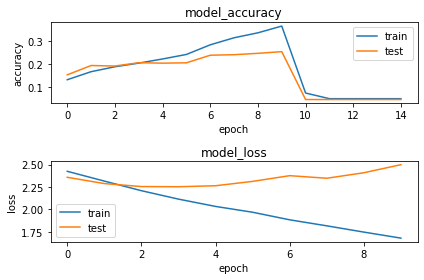

In [24]:
# Plot the history
_, (ax1, ax2) = plt.subplots(2)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title(f'model_accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title(f'model_loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='best')
plt.tight_layout()

# Section 4: Predictions

After the training, we are ready to make predictions.
We load the locally saved model in the checkpoints directory. We then use the model's `predict` function to predict the test set.

In [25]:
from tensorflow.keras.models import load_model

In [26]:
path_to_model = "./checkpoints/weights-improvement-10-0.26.hdf5"
model = load_model(path_to_model)

In [28]:
# Make predicions
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Section 5: Evaluation

Using the predictions, We evaluate our model using the `Confusion Matrix` and `Classification Report`

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
print('Confusion Matrix:\n')
print(confusion_matrix(np.argmax(test_labels, axis=1), y_pred))

Confusion Matrix:

[[ 21   0  15   6   2  13  35   0   0  76   3  19]
 [  8   0  21  11   5  21  58   0   0  65   1  29]
 [ 14   0 164   5  48  52  67   0   0 121   4  29]
 [ 18   0  24  45   3  23 105   0   0  73  11  49]
 [  5   0  83   3 223  50  31   0   0  80   2  11]
 [  1   0  51   6  10 114 128   0   0  66   2  20]
 [ 13   0  17  15   7  72 200   0   0  73   4  35]
 [  8   0  10   9   1  26  67   0   0  49   4  38]
 [  8   0  23   2   1  16  53   0   0  59   2  19]
 [  8   1  48  15   6  42  66   0   0 120   4  36]
 [  3   0  13   8   1  15  33   0   0  49  83  33]
 [ 20   0  38  17   7  42 145   0   0 104  10  52]]


In [43]:
print('Classification Report:\n')
target_names = list(data['star'].unique())
print(classification_report(np.argmax(test_labels, axis=1),
                            y_pred, target_names=target_names))

Classification Report:

              precision    recall  f1-score   support

      Pisces       0.17      0.11      0.13       190
       Virgo       0.00      0.00      0.00       219
      Taurus       0.32      0.33      0.32       504
      Gemini       0.32      0.13      0.18       351
   Capricorn       0.71      0.46      0.56       488
       Aries       0.23      0.29      0.26       398
     Scorpio       0.20      0.46      0.28       436
      Cancer       0.00      0.00      0.00       212
    Aquarius       0.00      0.00      0.00       183
 Sagittarius       0.13      0.35      0.19       346
         Leo       0.64      0.35      0.45       238
       Libra       0.14      0.12      0.13       435

    accuracy                           0.26      4000
   macro avg       0.24      0.22      0.21      4000
weighted avg       0.27      0.26      0.24      4000



/home/ibtihaj/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion

Summary of the task is

  - We get the XML file names.
  - We Extract the gender and star from the file name.
  - We open a file and load it's content.
  - We determine the type of encoding of the content.
  - We Parse the XML content with the determined encoding and find all the posts.
  - For every post found, we apply text preprocessing steps.
  - We append the processsed post along it's label and gender.
  - We use that list to make a dataframe and store the data in it.
  - We then locally store the csv file.
  - We load the csv and do some analysis.
  - We do some further processing to form the data in a format a deep learning model expects.
  - We create a simple model
  - We train the model and then evaluate it.
  
The results of the model can further be improved for more data and more number of epochs.

# Prediction for Arbisoft Evaluation

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from os import listdir
from bs4 import BeautifulSoup
import chardet
from tqdm import tqdm
import pandas as pd
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ibtihaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ibtihaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ibtihaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ibtihaj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
def predict(xml_file):
    '''
        This method assumes the data to be in a xml file just like the dataset. 
        It will load a model locally that was stored after training and use it to predict the class.
    '''

    # Star Classes
    classes = ['Pisces', 'Virgo', 'Taurus', 'Gemini', 'Capricorn', 'Aries',
               'Scorpio', 'Cancer', 'Aquarius', 'Sagittarius', 'Leo', 'Libra']

    # Load the trained model saved locally
    model = load_model("./checkpoints/weights-improvement-10-0.26.hdf5")

    # List to hold all the preprocessed posts
    post_data = list()

    # Load the file content
    with open(xml_file, 'rb') as xml_fileObject:

        # Get the content of the file
        content = xml_fileObject.read()

        # Detect the encoding
        encoding = chardet.detect(content)

        # Beautiful Soup to parse the XML
        soup = BeautifulSoup(
            content, 'xml', from_encoding=encoding['encoding'])

        # Find all `post` tags
        posts = soup.find_all('post')

        # For every post found
        for post in posts:

            # Get the post text in `str` format
            post_text = post.get_text()

            # 1. LowerCase the text
            text_lower = post_text.lower()

            # 2. Remove Numbers
            text_wo_numbers = re.sub(r'\d+', '', text_lower)

            # 3. Remove Punctuations
            PUNCT_TO_REMOVE = string.punctuation
            text_wo_punctuation = text_wo_numbers.translate(
                str.maketrans('', '', PUNCT_TO_REMOVE))

            # 4. Remove White Space
            text_wo_whitespace = text_wo_punctuation.strip()

            # 5. Remove Stop Words
            STOPWORDS = set(stopwords.words('english'))
            text_wo_stop = " ".join([word for word in str(
                text_wo_whitespace).split() if word not in STOPWORDS])

            # 6. Lemmatization
            lemmatizer = WordNetLemmatizer()
            wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB,
                           "J": wordnet.ADJ, "R": wordnet.ADV}
            pos_tagged_text = nltk.pos_tag(text_wo_stop.split())
            text_lemmatized = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(
                pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

            # 7. Removal of URLs
            url_pattern = re.compile(r'https?://\S+|www\.\S+')
            text_wo_urls = url_pattern.sub(r'', text_lemmatized)

            post_data.append(text_wo_urls)

    # Cast to a numpy array
    post_data = np.array(post_data)

    # Create a tokenizer object
    tokenizer = Tokenizer()

    # Fit tokenizer on post_data
    tokenizer.fit_on_texts(post_data)

    # Convert to sequence
    post_data = tokenizer.texts_to_sequences(post_data)

    # Get the vocab size
    vocab_size = len(tokenizer.word_index) + 1

    # Pad the sequence (if required)
    max_len = 250
    post_data = pad_sequences(post_data, padding='post', maxlen=max_len)

    # Make predictions
    prediction = model.predict(post_data)
    prediction = np.argmax(np.argmax(prediction, axis=1))
    print(classes[prediction])

In [58]:
test = "./data/blogs_train/1009572.male.25.indUnk.Cancer.xml"

In [59]:
predict(test)

Pisces
